In [1]:
import os
import time
import matplotlib.pyplot as plt

from monai.config import print_config
from monai.data import DataLoader, decollate_batch, Dataset, ArrayDataset
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from sklearn.model_selection import train_test_split
from monai.transforms import (
    Activations,

    AsDiscrete,
    AsDiscreted,
    Compose,
 
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    CropForegroundd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    SpatialPadd,
    SpatialCropd,
    ScaleIntensityd,
    ShiftIntensityd,
    ResizeD,
    AdjustContrastd,
    RandGaussianSharpend,
    RandHistogramShiftd,
    RandStdShiftIntensityd,
    RandAdjustContrastd
    
)
from monai.utils import set_determinism
import numpy as np
import torch

import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import SegResNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Activations, AsDiscrete
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset
from monai.utils import set_determinism
import os
import nibabel as nib
import numpy as np

import torch
from monai.transforms import Transform,ThresholdIntensity, RandCropByPosNegLabeld,Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, NormalizeIntensityd, ResizeD,RandAffined, RandFlip
from monai.transforms import (
    AsDiscreted,
    Compose,

    LoadImaged,

)

import os
from monai.transforms import Compose, LoadImaged, AddChanneld, ScaleIntensityRanged, ToTensord

print_config()



MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.12
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.5.0
Tensorboard version: 2.12.3
gdown version: 4.7.1
TorchVision version: 0.15.2+cu117
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.5
pandas version: 2.0.1
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.3.2
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
data_dir =  "/home/Task07_Pancreas/"
images_dir = os.path.join(data_dir, "imagesTr")
labels_dir = os.path.join(data_dir, "labelsTr")

In [3]:
# Get image and label file paths
image_files = sorted([os.path.join(images_dir, x) for x in os.listdir(images_dir) if x.endswith(".nii.gz")])
label_files = sorted([os.path.join(labels_dir, x) for x in os.listdir(labels_dir) if x.endswith(".nii.gz")])


In [4]:
# Make sure the images and labels correspond correctly
assert len(image_files) == len(label_files)
for im, lab in zip(image_files, label_files):
    assert os.path.splitext(os.path.basename(im))[0] == os.path.splitext(os.path.basename(lab))[0]


In [11]:
# Determine the number of samples to load
num_samples_to_load = len(image_files) // 10

# Create a list of dictionaries where each dictionary represents one sample
data_dicts = [{"image": image, "label": label} for image, label in zip(image_files[:num_samples_to_load], label_files[:num_samples_to_load])]


In [12]:
train_data_dicts, val_data_dicts = train_test_split(data_dicts, test_size=0.2, random_state=42)


In [13]:
class ConvertToSingleLabel(Transform):
    def __call__(self, data):
        label = data["label"]
        # Keep only the second and third channels from the label
        single_label = label[1:2]

        data["label"] = single_label
        return data


In [20]:


train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    ScaleIntensityRanged(keys="image", a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    AsDiscreted(keys='label', to_onehot=3),
    ConvertToSingleLabel(),
    CropForegroundd(keys=["image", "label"], source_key="image"),  # Crop the foreground of the image and label
    Spacingd(keys=["image", "label"], pixdim=[1.0, 1.0, 1.0]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    # ResizeD(keys=["image", "label"], spatial_size=[512, 512, 288], mode=("trilinear", "nearest")),  # Resize image and label
    # RandCropByPosNegLabeld(
    #     keys=["image", "label"],
    #     label_key="label",
    #     spatial_size=(224, 224, 144),
    #     pos=3,
    #     neg=1,
    #     num_samples=2,
    #     image_key="image"
    # ),
    RandAffined(keys=["image", "label"],prob=0.5, translate_range=(10, 10, 5), rotate_range=(np.pi / 6, np.pi / 6, np.pi / 6), scale_range=(0.1, 0.1, 0.1)),
    ResizeD(keys=["image", "label"], spatial_size=[96, 96, 64], mode=("trilinear", "nearest")),  # Resize image and label
    # ThresholdIntensity(keys="label", threshold=0.5, above=True, below=False),  # Binarize the label tensor
    ToTensord(keys=["image", "label"]),
])


# Define transforms for validation dataset
val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    ScaleIntensityRanged(keys="image", a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    AsDiscreted(keys='label', to_onehot=3),
    ConvertToSingleLabel(),
    CropForegroundd(keys=["image", "label"], source_key="image"),  # Crop the foreground of the image and label
    Spacingd(keys=["image", "label"], pixdim=[1.0, 1.0, 1.0]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ResizeD(keys=["image", "label"], spatial_size=[96, 96, 64], mode=("trilinear", "nearest")),  # Resize image and label
    # ThresholdIntensity(keys="label", threshold=0.5, above=True, below=False),  # Binarize the label tensor
    ToTensord(keys=["image", "label"]),
])

In [21]:
train_dataset = Dataset(data=train_data_dicts, transform=train_transforms)
val_dataset = Dataset(data=val_data_dicts, transform=val_transforms)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [22]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 22
Number of validation samples: 6


In [23]:
# Get the first sample in the dataset
first_sample = train_dataset[0]


image_shape = first_sample['image'].shape
label_shape = first_sample['label'].shape

print(f"Image shape: {image_shape}")
print(f"Label shape: {label_shape}")


Image shape: torch.Size([1, 96, 96, 64])
Label shape: torch.Size([1, 96, 96, 64])


In [25]:
# Create the training dataset with binarized labels
binarized_train_labels = []
threshold=0.5
for sample in train_dataset:
    label_tensor = sample['label']
    binarized_label_tensor = torch.where(label_tensor > threshold, torch.tensor(1), torch.tensor(0))
    binarized_train_labels.append(binarized_label_tensor)

train_dataset_with_binarized_labels = Dataset(data=train_data_dicts, transform=train_transforms)
train_dataset_with_binarized_labels.data = [{'image': sample['image'], 'label': binarized_label.unsqueeze(0)} for sample, binarized_label in zip(train_dataset, binarized_train_labels)]

# Create the validation dataset with binarized labels
binarized_val_labels = []
for sample in val_dataset:
    label_tensor = sample['label']
    binarized_label_tensor = torch.where(label_tensor > threshold, torch.tensor(1), torch.tensor(0))
    binarized_val_labels.append(binarized_label_tensor)

val_dataset_with_binarized_labels = Dataset(data=val_data_dicts, transform=val_transforms)
val_dataset_with_binarized_labels.data = [{'image': sample['image'], 'label': binarized_label.unsqueeze(0)} for sample, binarized_label in zip(val_dataset, binarized_val_labels)]

# Create the data loaders
train_loader = DataLoader(train_dataset_with_binarized_labels, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset_with_binarized_labels, batch_size=1, shuffle=False)

32


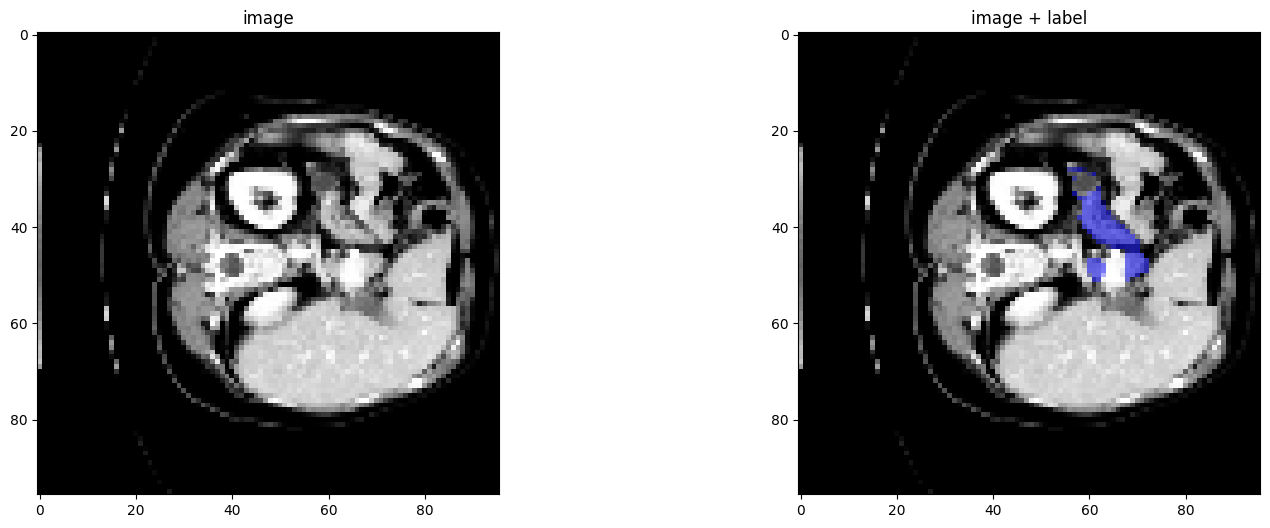

32


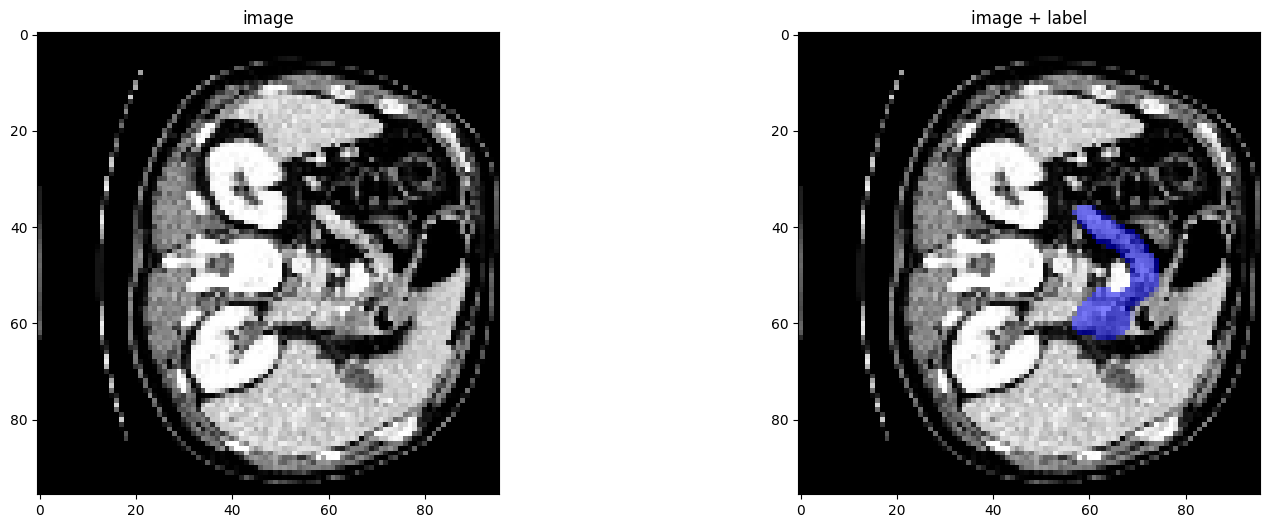

In [27]:
colors = [(0, 0, 1, i) for i in np.linspace(0, 1, 100)]
blue_cmap = mcolors.LinearSegmentedColormap.from_list('blue_alpha', colors)

colors = [(1, 0, 0, i) for i in np.linspace(0, 1, 100)]
red_cmap = mcolors.LinearSegmentedColormap.from_list('red_alpha',colors)
for i in range(1,3):                                               
    val_data_example=train_dataset[i]
    # Select a slice to visualize (e.g., the middle slice)
    slice_idx = val_data_example['image'].shape[3] // 2  # adjust to the depth dimension
    print(slice_idx)
    # Get image and labels
    image = val_data_example['image'][0, :, :, slice_idx].detach().cpu()

    label2 = val_data_example['label'][0, :, :, slice_idx].detach().cpu()

    # Create a figure
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap='gray')

    # Overlay the labels
    # We're using different colors and transparency (alpha) for each label
    plt.subplot(1, 2, 2)
    plt.title("image + label")
    plt.imshow(image, cmap='gray')
    plt.imshow(label2, cmap=blue_cmap, alpha=0.5)  # Use alpha for transparency


    # plt.axis('off')  # To not show axis
    plt.show()


In [32]:

# Define your UNet model as a function
def unet(in_channels, out_channels):
    model = SegResNet(
        blocks_down=[1, 2, 2, 4],
        blocks_up=[1, 1, 1],
        init_filters=16,
        in_channels=in_channels,
        out_channels=out_channels,
        dropout_prob=0.2,
    )
    return model

In [33]:

device = torch.device('cuda')
num_gpus = torch.cuda.device_count()

device_ids = [1]  # Specify the GPU device IDs to be used
print("Using", num_gpus, "GPUs!")

# Define your UNet model
in_channels = 1
out_channels = 1
model = unet(in_channels, out_channels)
model = model.to(device)
if torch.cuda.device_count() > 1:
    print("Using ", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=device_ids)

# Rest of the code
max_epochs = 100
val_interval = 1
VAL_AMP = True

loss_function = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(224, 224, 144),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True

best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
model_dir = "/home/model_codes/"
max_epochs = 100

Using 3 GPUs!
Using  3 GPUs!


In [34]:



total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
 
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_dataset) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = torch.round(torch.sigmoid(val_outputs))  # Apply threshold for binary segmentation
                metric = dice_metric(val_outputs, val_labels).item()
                metric_values.append(metric)

            mean_metric = sum(metric_values) / len(metric_values)
            if mean_metric > best_metric:
                best_metric = mean_metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(model, os.path.join(model_dir, "best_metric_model_single.pth"))
                print("Saved new best metric model")
                
     

            print(
                f"current epoch: {epoch + 1} current mean dice: {mean_metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start


----------
epoch 1/100


RuntimeError: applying transform <monai.transforms.compose.Compose object at 0x7fcfc71b4cd0>

Using  3 GPUs!


In [1]:
model_dir =  "/home/model_codes/"
torch.save(
    model.state_dict(),
    os.path.join(model_dir, "best_metric_model_bg_v4.pth"),
)
print("saved new best metric model")

NameError: name 'torch' is not defined

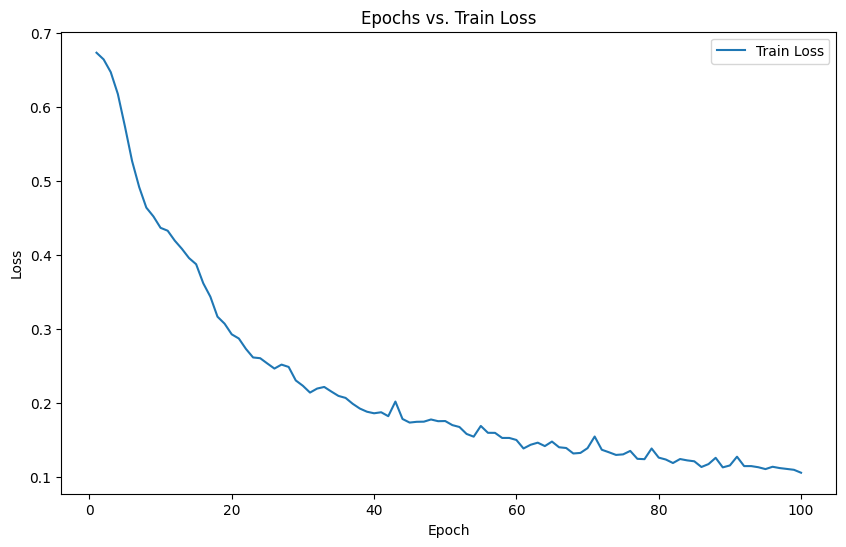

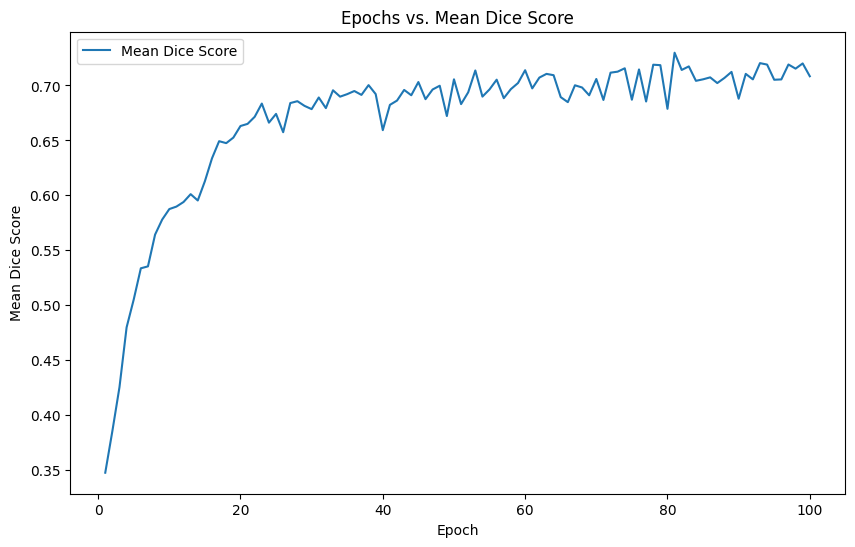

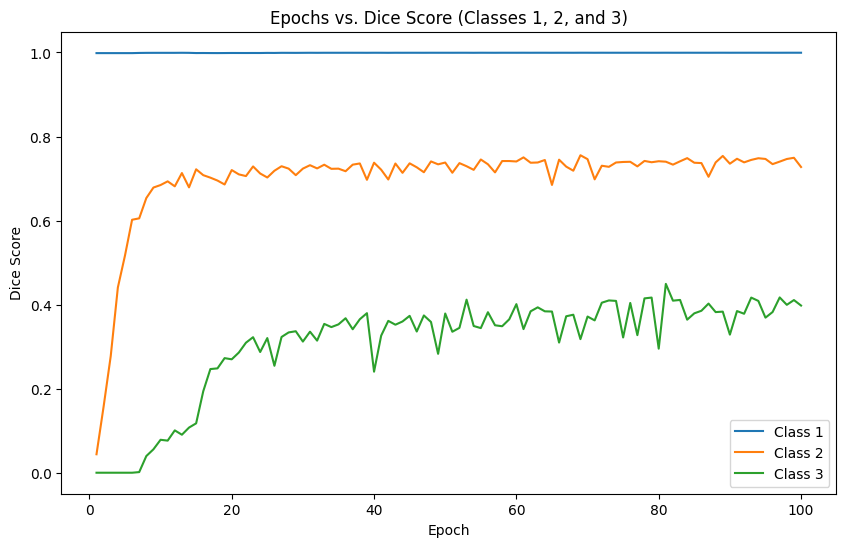

: 

In [19]:
import matplotlib.pyplot as plt

# Plot epochs vs train loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_epochs + 1), epoch_loss_values, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epochs vs. Train Loss')
plt.legend()
plt.show()

# Plot epochs vs mean dice score
plt.figure(figsize=(10, 6))
plt.plot(range(val_interval, max_epochs + 1, val_interval), metric_values, label='Mean Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Mean Dice Score')
plt.title('Epochs vs. Mean Dice Score')
plt.legend()
plt.show()

# Plot epochs vs class 1, 2, and 3 dice scores
plt.figure(figsize=(10, 6))
plt.plot(range(val_interval, max_epochs + 1, val_interval), metric_values_class1, label='Pancreas')
plt.plot(range(val_interval, max_epochs + 1, val_interval), metric_values_class2, label='Tumor')

plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Epochs vs. Dice Score (Pancreas and Tumor)')
plt.legend()
plt.show()
